<h1>Raster Fairy - Warping</h1>
<p>Version 1.0<br/>Author: Mario Klingemann | @Quasimondo</p>
<p>Raster Fairy also allows to warp a 2D point cloud by means of a Coons Patch. This warp will not align the points to a grid, but allow to reshape the cloud into a different form whilst still preserving the neighborhood relations.</p>
<p>Let's start by creating an example dataset consisting of 2000 random RGB points and calculate a 2D t-sne embedding from it. Of course you can use any other clustering method or whatever 2D points you have lying around. </p>

/home/quasimondo/.local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


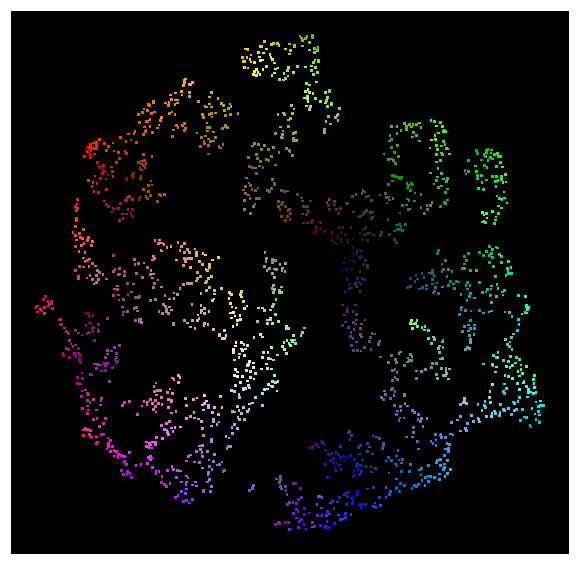

In [1]:
# just some basic setup for the purpose of this demo:
%matplotlib inline  
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

from sklearn.manifold import TSNE
#alternative you can use bh_sne:
#from tsne import bh_sne


# generate a set of 4900 random 3D points
totalDataPoints = 2000 
dataPoints = np.random.uniform(low=0.0, high=1.0, size=(totalDataPoints,3))

# create a t-sne embedding in 2D (we have to clone the array since bh_sne changes the original data)
# The bh_sne repository can be found here: https://github.com/danielfrg/tsne
#xy = bh_sne(dataPoints.copy())

xy = TSNE().fit_transform(dataPoints)


fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(xy[:,0],xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=7.5)    
plt.show()


The default method tries to warp the cloud towards a square shape. It does that by calculating the outer hull of the cloud and remapping it to a rectangle. The perimeterSubdivisionSteps parameter controls how concave the hull is. A value of 0 is the equivalent of a convex hull, the higher the value becomes the more the hull tries to "creep" into gaps. You have to experiment with this value depending on the shape of the hull - too high values will often result in most of the points being drawn to the edges. The autoPerimeterOffset will look for the grid that best matches the density distribution of the cloud, but will also often result in a rotation of the cloud. The width and height parameters control the resolution of the Coons Patch and will influence how continouus the mapping is. The default values of 64 should give good results in most cases. The paddingScale parameter controls the offset of the patch's hull from the cloud - the bigger the value the less pronounced the warping effect will be.

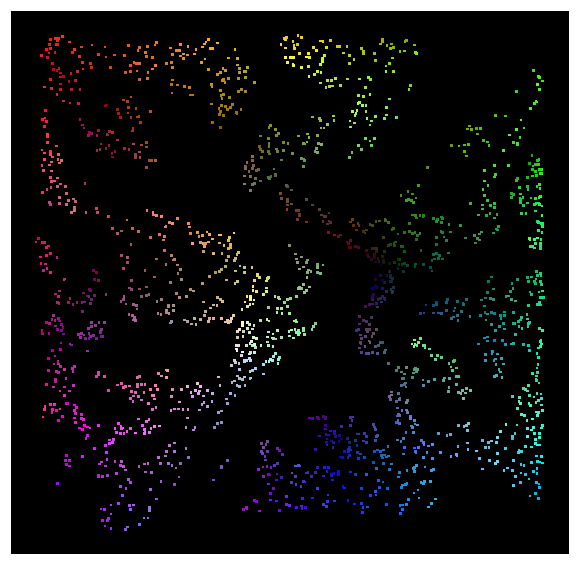

In [2]:
from rasterfairy import coonswarp

warped_xy = coonswarp.rectifyCloud(xy,perimeterSubdivisionSteps=4,autoPerimeterOffset=False, paddingScale=1.05)

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(warped_xy[:,0],warped_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=7.5)    
plt.show()

Here is another example that shows how to use a different target grid, in this case a circle, to warp the cloud. Also The source and target grids are shown in the rendering:

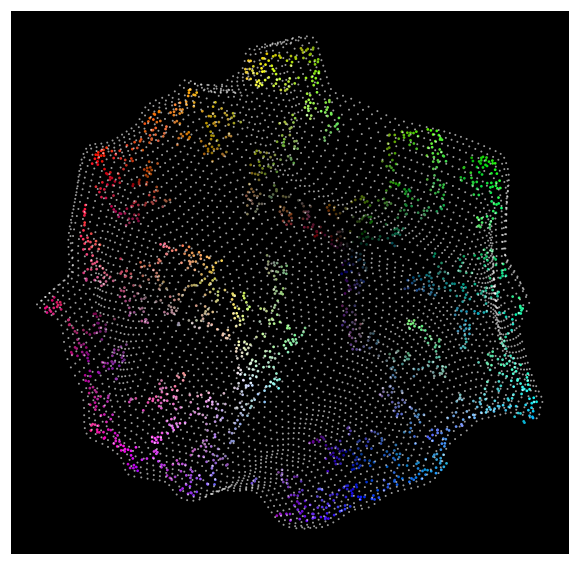

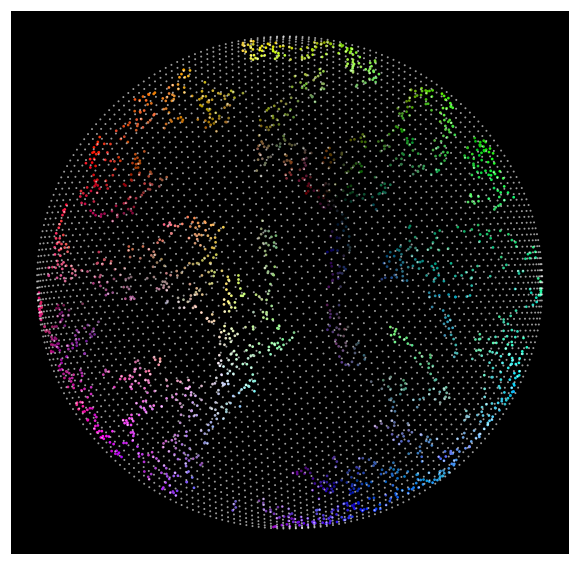

In [3]:
sourceGrid = coonswarp.getCloudGrid( xy, perimeterSubdivisionSteps=2,autoPerimeterOffset=False, perimeterOffset=64,paddingScale=1.05, smoothing = 0.5)
targetGrid = coonswarp.getCircularGrid(xy)
warped_xy  = coonswarp.warpCloud(xy,sourceGrid,targetGrid)


fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(xy[:,0],xy[:,1], c = dataPoints,  edgecolors='none',s=7.5)   
ax.scatter(sourceGrid[:,0],sourceGrid[:,1], c = 'w',  edgecolors='none',s=4,alpha=0.6)   


fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(warped_xy[:,0],warped_xy[:,1], c = dataPoints,  edgecolors='none',s=7.5)   
ax.scatter(targetGrid[:,0],targetGrid[:,1], c = 'w',  edgecolors='none',s=4,alpha=0.6)   

plt.show()

Here is a snippet that renders an animation of the warp to an animated gif:

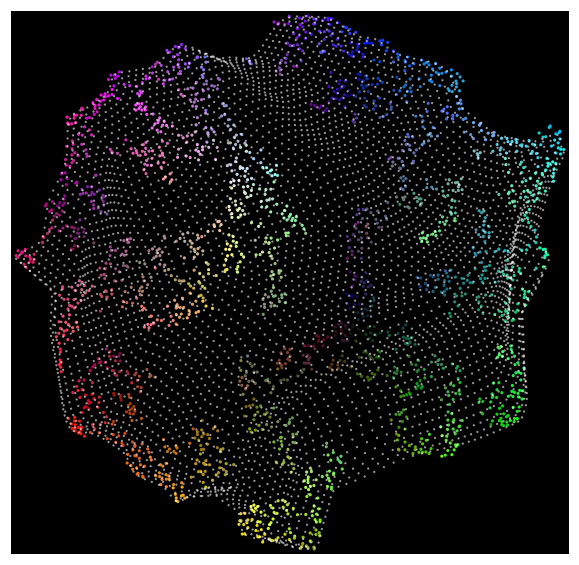


[MoviePy] Building file ../warp_demo.gif with imageio


100%|██████████| 101/101 [00:06<00:00, 15.28it/s]


In [4]:
import io
from moviepy.editor import *
import PIL.Image as PImage
from IPython.display import clear_output, Image
from sklearn.cluster import KMeans

pointCount = len(xy)
gridPointCount = len(sourceGrid)
# some color reduction since the NeuQuant color reduction of images2gif does a bad job in this case:
kmeans = KMeans(n_clusters=min(255,pointCount), random_state=0).fit(dataPoints)
reducedColors = kmeans.cluster_centers_[kmeans.predict(dataPoints)]

width = 64
height = 64

images = []

# a bit of coordinate normalization so the coordinates are in the same range:
px_from = xy[:,0] - min(xy[:,0])
py_from = xy[:,1] - min(xy[:,1])

px_from /= max(px_from)
py_from /= max(py_from)

px_to = warped_xy[:,0] - min(warped_xy[:,0])
py_to = warped_xy[:,1] - min(warped_xy[:,1])

px_to /= max(px_to)
py_to /= max(py_to)

    
gx_from = sourceGrid[:,0] - min(sourceGrid[:,0])
gy_from = sourceGrid[:,1] - min(sourceGrid[:,1])

gx_from /= max(gx_from)
gy_from /= max(gy_from)

gx_to = targetGrid[:,0] - min(targetGrid[:,0])
gy_to = targetGrid[:,1] - min(targetGrid[:,1])

gx_to /= max(gx_to)
gy_to /= max(gy_to)


steps = 50

for i in range(steps*2):
    
    t = 1.0- abs(1.0 * i / float(steps-1)-1.0) #tsteps[steps]
    #t= 1.0 * i / (steps-1)
    dx = []
    dy = []
    for j in range( pointCount ):
        dx.append( (1.0-t)*px_from[j] + t*px_to[j])
        dy.append( (1.0-t)*py_from[j] + t*py_to[j] )
        
    gx = []
    gy = []
    for j in range( gridPointCount ):
        gx.append( (1.0-t)*gx_from[j] + t*gx_to[j])
        gy.append( (1.0-t)*gy_from[j] + t*gy_to[j] )
    
    fig2 = plt.figure(figsize=(10.0,10.0))
    ax = fig2.add_subplot(1, 1, 1)
    ax.set_facecolor('black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.scatter(dx,dy, c = reducedColors,  edgecolors='none',s=10.0) #,marker='s'
    ax.scatter(gx,gy, c = 'w', alpha=0.6, edgecolors='none',s=5.0) #,marker='s'
    ax.axes.set_xlim([-0.01,1.01])
    ax.axes.set_ylim([-0.01,1.01])
    
    clear_output(wait=True)
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    images.append( np.array(PImage.open(buf)) )
    
    
    #in case you want to rather export a series of PNGs:
    #plt.savefig('clusters/cluster'+"%03d" % (i+steps,)+'.png')
    plt.show()
    
clip = ImageSequenceClip(images,fps=25)
clip.write_gif("../warp_demo.gif")                 
Image(url="../warp_demo.gif")
